In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)

In [54]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,82.458725,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,84.001442,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,84.439499,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,84.544243,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,83.925255,7296900
2019-12-18,88.389999,88.849998,87.820000,87.989998,83.791939,5859200
2019-12-19,87.830002,88.589996,87.580002,88.519997,84.296638,6022100
2019-12-20,88.790001,89.000000,87.889999,88.459999,84.239517,14271500
2019-12-23,88.620003,88.849998,88.180000,88.230003,84.020500,4349700


<AxesSubplot:title={'center':'Starbucks Stock Volume'}, xlabel='Date'>

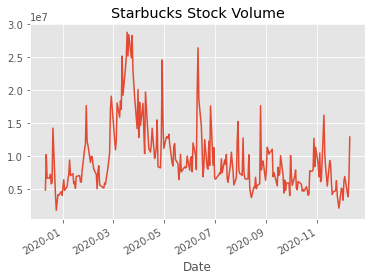

In [55]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Starbucks Stock Volume')

In [109]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6] 
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   82.458725
2019-12-12   88.000000   88.889999   87.540001   88.209999   84.001442
2019-12-13   88.019997   88.790001   87.580002   88.669998   84.439499
2019-12-16   89.139999   89.300003   88.430000   88.779999   84.544243
2019-12-17   88.870003   88.970001   87.470001   88.129997   83.925255
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999   99.408981
2020-12-07  102.010002  102.220001  100.690002  101.410004   98.563400
2020-12-08  100.370003  101.570000  100.010002  101.209999   98.369026
2020-12-09  101.940002  102.209999  100.099998  100.400002   97.581757
2020-12-10  103.510002  106.089996  102.750000  105.389999  102.431694

[253 rows x 5 columns]
              Volume
Date                
2019-12-11 

In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [63]:
#first 200 for training

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :] 

In [64]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [65]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [66]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [67]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [101]:
num_epochs = 1000
learning_rate = 0.001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1

In [102]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final[1])

In [103]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [104]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3f}")

Epoch: 0, loss: 0.07659614831209183
Epoch: 100, loss: 0.036839455366134644
Epoch: 200, loss: 0.03152376413345337
Epoch: 300, loss: 0.02161284163594246
Epoch: 400, loss: 0.016031131148338318
Epoch: 500, loss: 0.01455176342278719
Epoch: 600, loss: 0.012730730697512627
Epoch: 700, loss: 0.01190798357129097
Epoch: 800, loss: 0.011635960079729557
Epoch: 900, loss: 0.011479510925710201
Epoch: 1000, loss: 0.011366431601345539
Epoch: 1100, loss: 0.01127440482378006
Epoch: 1200, loss: 0.011201417073607445
Epoch: 1300, loss: 0.01113912370055914
Epoch: 1400, loss: 0.011085506528615952
Epoch: 1500, loss: 0.010928746312856674
Epoch: 1600, loss: 0.010753674432635307
Epoch: 1700, loss: 0.010684766806662083
Epoch: 1800, loss: 0.010626389645040035
Epoch: 1900, loss: 0.010574660263955593
Epoch: 2000, loss: 0.01052958332002163
Epoch: 2100, loss: 0.010491265915334225
Epoch: 2200, loss: 0.010461561381816864
Epoch: 2300, loss: 0.010438698343932629
Epoch: 2400, loss: 0.010418009012937546
Epoch: 2500, loss: 0

In [105]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

In [106]:
df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

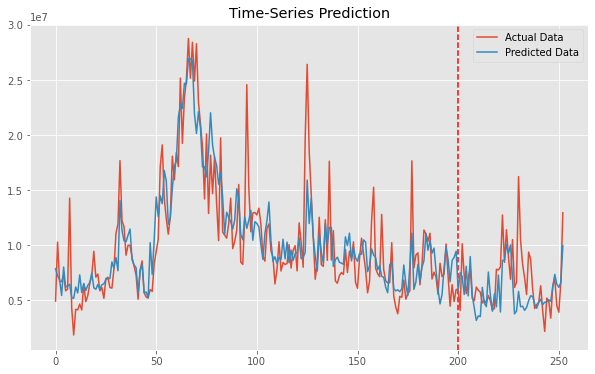

In [107]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 